# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

In [ ]:
!unzip ATnT.zip

#### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [3]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [4]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement PCA by taking the following arguments:
    1. X (images array)
    2. numComponents (number of components)

    Returns the eigen vectors (principal components) termed "Eigen faces"
    """
    # Reshape the images array to a 2D array (each row represents a flattened image)
    X_flat = X.reshape(X.shape[0], -1)

    # Print the shape of X_flat before reshaping for debugging
    print("X_flat shape (before reshape):", X_flat.shape)

    # Ensure X_flat has the correct shape
    if len(X_flat.shape) > 1 and X_flat.shape[1] == 1:
        X_flat = X_flat.flatten()

    # Print the shape of X_flat after reshaping for debugging
    print("X_flat shape (after reshape):", X_flat.shape)

    # Check if X_flat contains any None values
    if np.any(X_flat is None):
        raise ValueError("X_flat contains None values. Please check the input data.")

    # Calculate the mean face
    meanFace = np.mean(X_flat, axis=0, keepdims=True)

    # Print the shape of meanFace for debugging
    print("meanFace shape:", meanFace.shape)

    # Center the data
    centered_faces = X_flat - meanFace

    # Calculate the covariance matrix
    cov_matrix = np.cov(centered_faces, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and corresponding eigenvectors in descending order
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Select the top 'numComponents' eigenvectors
    eigenFaces = eigenvectors[:, :numComponents]

    return meanFace, eigenFaces


X_flat shape (before reshape): (360, 10304)
X_flat shape (after reshape): (360, 10304)
meanFace shape: (1, 10304)


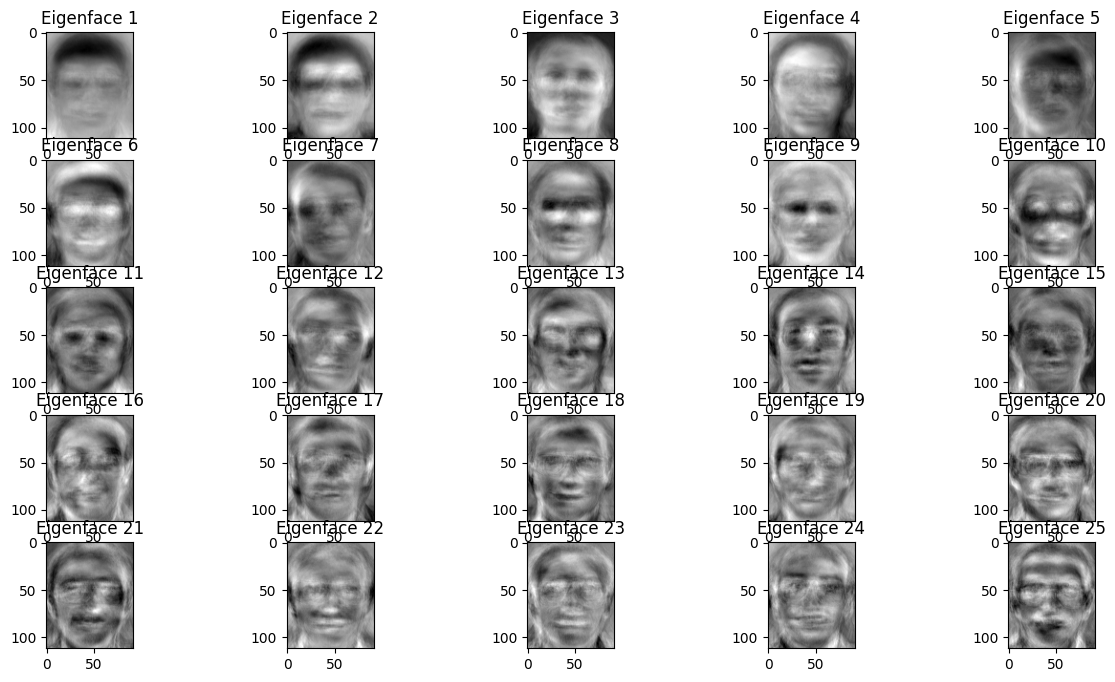

In [5]:
# plot the eigen faces
def plot_eigenfaces(eigenFaces, numComponents):
    """
    Plot the eigenfaces generated by PCA
    """
    plt.figure(figsize=(15, 8))
    for i in range(min(25, numComponents)):  # Plot a maximum of 25 eigenfaces
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.reshape(eigenFaces[:, i], (112, 92)), cmap='gray')
        plt.title(f'Eigenface {i + 1}')

    plt.show()

# Define numComponents before calling the principalComponentAnalysis function
numComponents = 100  # You can choose a different number of components

# Assuming you have already executed the principalComponentAnalysis function
meanFace, eigenFaces = principalComponentAnalysis(trainFaces, numComponents)

# Plot the eigenfaces
plot_eigenfaces(eigenFaces, numComponents)



#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [6]:
def imageReconstruction(testFaces, eigenFaces, meanFace, numComponents):
    """
    Reconstruct faces using a specified number of eigenfaces.

    Parameters:
    - testFaces: Array of flattened representations of input faces.
    - eigenFaces: Matrix containing the eigenfaces as columns.
    - meanFace: Mean face of the training data.
    - numComponents: Number of components (eigenfaces) to use.

    Returns:
    - reconstructedFaces: Array of reconstructed faces.
    """

    # print("Shapes before centering:")
    # print(f"testFaces: {testFaces.shape}")
    # print(f"meanFace: {meanFace.shape}\n")

    # Flatten meanFace if needed
    meanFace_flat = meanFace.flatten()

    # Center the test faces
    centered_testFaces = testFaces - meanFace_flat.reshape((1, -1))

    # print("Shapes after centering:")
    # print(f"centered_testFaces: {centered_testFaces.shape}\n")

    # Calculate the weights for the eigenfaces
    weights = np.dot(centered_testFaces, eigenFaces[:, :numComponents])

    # print("Shapes after calculating weights:")
    # print(f"weights: {weights.shape}\n")

    # Reconstruct the faces using the specified number of components
    reconstructedFaces = meanFace_flat + np.dot(weights, eigenFaces[:, :numComponents].T)

    # print("Shapes after reconstruction:")
    # print(f"reconstructedFaces: {reconstructedFaces.shape}\n")

    return reconstructedFaces


# Plot reconstructions here:

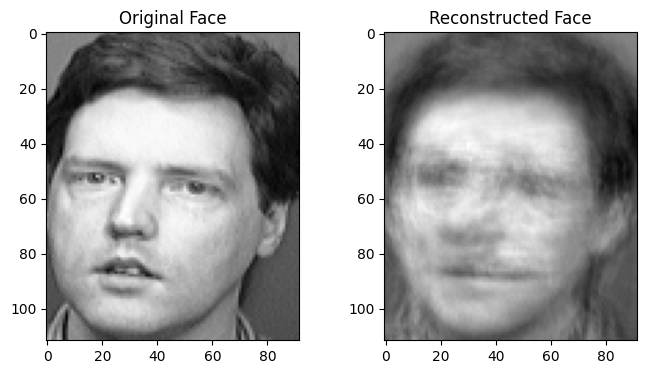

In [7]:
# Assuming you have already executed the principalComponentAnalysis and imageReconstruction functions

# Choose a test face for reconstruction
test_face_index = 0  # You can change this index to choose a different test face
test_face = testFaces[test_face_index].flatten()

# Reconstruct the test face
reconstructed_face = imageReconstruction(test_face, eigenFaces, meanFace,numComponents)

# Reshape the faces back to their original dimensions for plotting
original_face_reshaped = test_face.reshape((112, 92))
reconstructed_face_reshaped = reconstructed_face.reshape((112, 92))

# Plot the original and reconstructed faces
plt.figure(figsize=(8, 4))

# Original Face
plt.subplot(1, 2, 1)
plt.imshow(original_face_reshaped, cmap='gray')
plt.title('Original Face')

# Reconstructed Face
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face_reshaped, cmap='gray')
plt.title('Reconstructed Face')

plt.show()


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

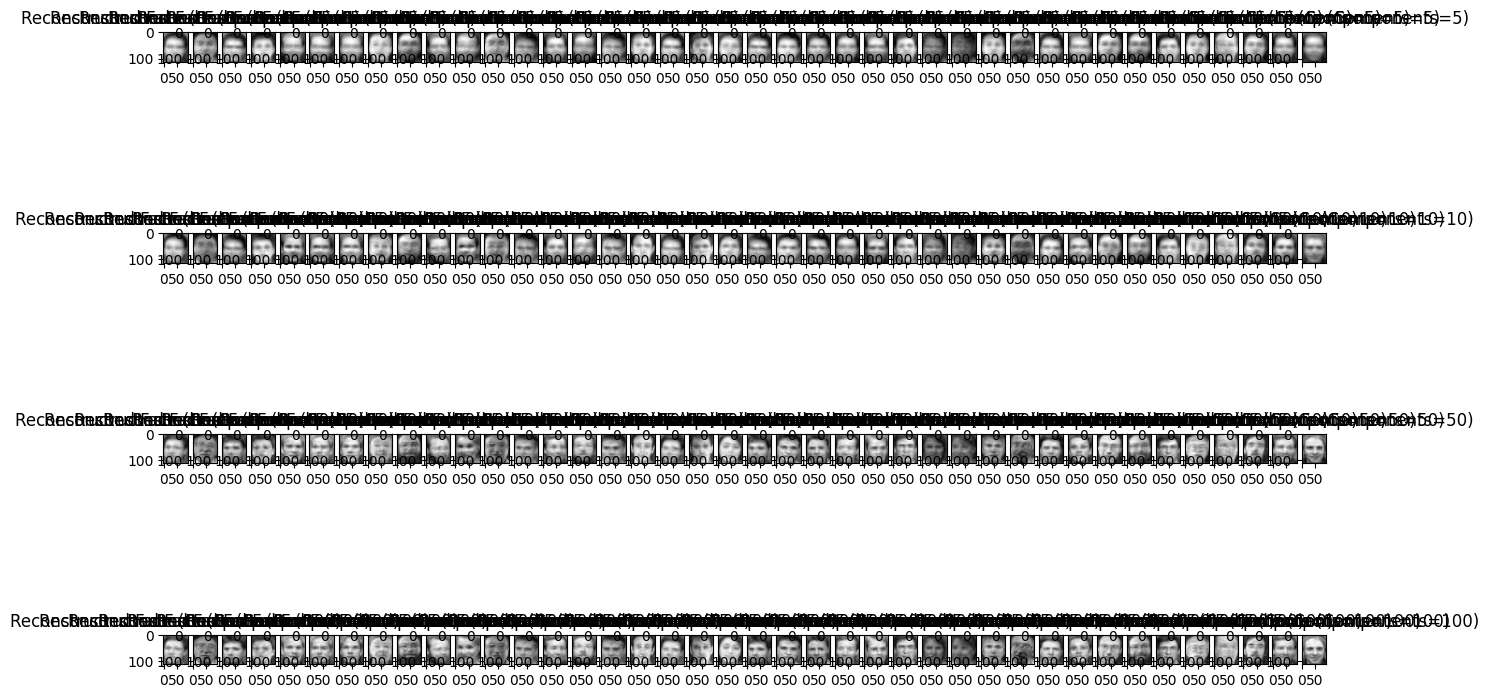

In [8]:
def displayNfactors(testFaces, eigenFaces, meanFace, numComponentsList):
    """
    Display reconstructed faces for different numbers of components.

    Parameters:
    - testFaces: Array of flattened representations of input faces.
    - eigenFaces: Matrix containing the eigenfaces as columns.
    - meanFace: Mean face of the training data.
    - numComponentsList: List of numbers of components to display.

    Returns:
    - None
    """

    plt.figure(figsize=(15, 10))

    for i, numComponents in enumerate(numComponentsList, 1):
        # Reconstruct each test face separately
        reconstructedFaces = [imageReconstruction(testFace.flatten(), eigenFaces, meanFace, numComponents) for testFace in testFaces]

        # Display the reconstructed faces in a grid
        for j, reconstructedFace in enumerate(reconstructedFaces, 1):
            plt.subplot(len(numComponentsList), len(testFaces), (i - 1) * len(testFaces) + j)
            plt.imshow(np.reshape(reconstructedFace, (112, 92)), cmap='gray')
            plt.title(f'Reconstructed Face (Components={numComponents})')

    plt.show()

# Call displayNfactors with your data
displayNfactors(testFaces, eigenFaces, meanFace, [5, 10, 50, 100])


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [9]:
def getClass(testFace, eigenFaces, meanFace, X_train, y_train, numComponents):
    weights_testFace = np.dot(testFace - meanFace.flatten(), eigenFaces[:, :numComponents])

    minError = float('inf')
    prediction = None
    reconstructedFace = None

    for i in range(X_train.shape[0]):
        # Print shapes for debugging
        # print("Shapes before calculating weights_trainFace:")
        # print(f"testFace: {testFace.shape}")
        # print(f"meanFace: {meanFace.flatten().shape}")
        # print(f"X_train[i]: {X_train[i].shape}")

        weights_trainFace = np.dot(X_train[i].flatten() - meanFace.flatten(), eigenFaces[:, :numComponents])

        # Print shapes for debugging
        # print("Shapes after calculating weights_trainFace:")
        # print(f"weights_trainFace: {weights_trainFace.shape}")

        error = np.linalg.norm(weights_testFace - weights_trainFace)

        if error < minError:
            minError = error
            prediction = y_train[i]
            reconstructedFace = meanFace.flatten() + np.dot(weights_trainFace, eigenFaces[:, :numComponents].T)

    return reconstructedFace, minError, prediction


Iterate through all the images in the test data and test the accuracy by taking different number of components

In [10]:
components = [3, 5, 10, 20, 30, 40, 50]
mse_values = []

for numComponents in components:
    total_images = len(testFaces)
    correct_predictions = 0

    for i in range(total_images):
        test_face = testFaces[i].flatten()
        true_label = testLabels[i]

        # Ensure meanFace has compatible shape
        mean_face_flat = meanFace.flatten()

        # Calculate the weights for the current training face using the provided eigenvectors and mean eigenface
        weights_trainFace = np.dot(trainFaces[i].flatten() - mean_face_flat, eigenFaces[:, :numComponents])

        # Call getClass to get reconstructed face, error, and prediction
        reconstructed_face, min_error, prediction = getClass(test_face, eigenFaces[:, :numComponents], meanFace, trainFaces, trainLabels,numComponents)

        # Check if the predicted label matches the true label
        if prediction == true_label:
            correct_predictions += 1

    # Calculate accuracy for the current number of components
    accuracy = correct_predictions / total_images
    mse_values.append(1 - accuracy)

for i, numComponents in enumerate(components):
    print(f"Number of Components: {numComponents}, Accuracy:{accuracy} ,MSE: {mse_values[i]}")


Number of Components: 3, Accuracy:0.975 ,MSE: 0.22499999999999998
Number of Components: 5, Accuracy:0.975 ,MSE: 0.125
Number of Components: 10, Accuracy:0.975 ,MSE: 0.050000000000000044
Number of Components: 20, Accuracy:0.975 ,MSE: 0.07499999999999996
Number of Components: 30, Accuracy:0.975 ,MSE: 0.025000000000000022
Number of Components: 40, Accuracy:0.975 ,MSE: 0.025000000000000022
Number of Components: 50, Accuracy:0.975 ,MSE: 0.025000000000000022


Plot Number of eigenvectors vs Mean Square Error

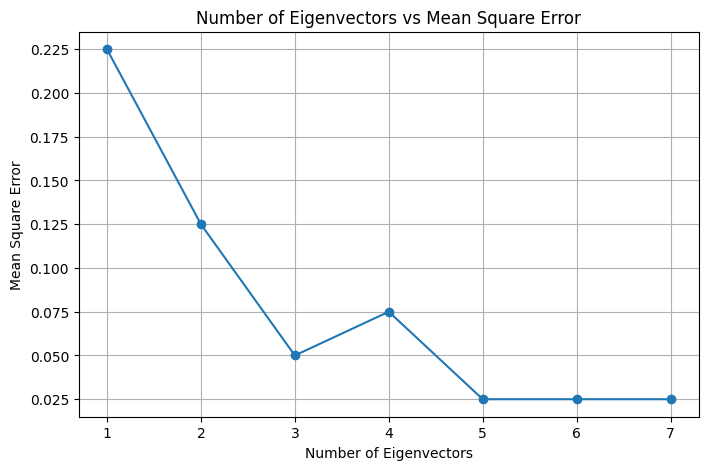

In [11]:
# your code here
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-')
plt.title('Number of Eigenvectors vs Mean Square Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Mean Square Error')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

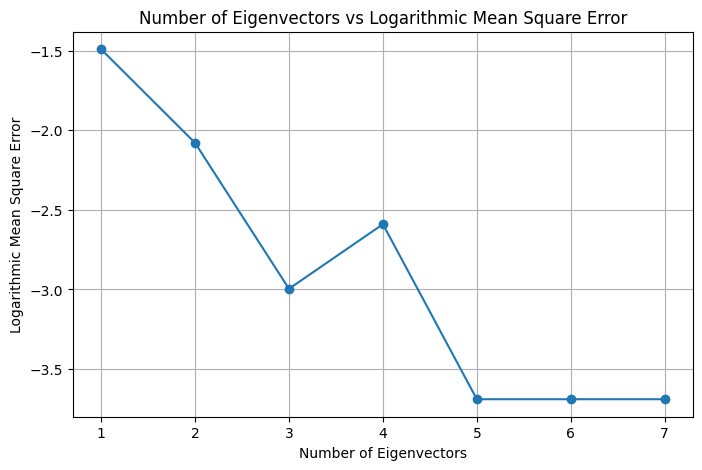

In [12]:
# your code here
log_mse_values = np.log(mse_values)

# Plotting the Number of Eigenvectors vs Logarithmic Mean Square Error
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(log_mse_values) + 1), log_mse_values, marker='o', linestyle='-')
plt.title('Number of Eigenvectors vs Logarithmic Mean Square Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Logarithmic Mean Square Error')
plt.grid(True)
plt.show()